# Grouping 

### Import Libraries

This cell imports the necessary Python libraries for data manipulation, preprocessing, dimensionality reduction, clustering, and visualization. Key libraries include:

- pandas and numpy for data handling
- sklearn for machine learning algorithms and preprocessing
- matplotlib for plotting
- scipy for additional statistical functions
- joblib for model persistence


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
import joblib

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Load PCA-transformed data

In [5]:
file_path = Path(r"C:\Programowanie\.vscode\projekt_people_analytics\DMI\DMI-Project\DMI-Project\data\03_processed\05_data_pca_21_comp.csv")
data_pca = pd.read_csv(file_path)

### K-Means Clustering Function

The `kmeans_clustering` function performs K-Means clustering on a given dataset to determine the optimal number of clusters using silhouette analysis. It visualizes the silhouette scores for different numbers of clusters and the resulting clusters in a scatter plot.

In [6]:
# K means
def kmeans_clustering(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), silhouette_scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('K-Means: Silhouette Analysis')
    
    plt.subplot(1, 2, 2)
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='viridis')
    plt.title(f'K-Means Clustering (k={optimal_clusters})')
    plt.tight_layout()
    plt.show()
    
    return kmeans_labels

### `dbscan_clustering` Function

The `dbscan_clustering` function performs clustering on the provided data using the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm and visualizes the clustering results.

#### Parameters

- `data` (pandas DataFrame): The input data to be clustered, assumed to have at least two columns.
- `eps` (float, default=0.5): The maximum distance between two samples for them to be considered as in the same neighborhood.
- `min_samples` (int, default=5): The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

#### Returns

- `dbscan_labels` (numpy array): The cluster labels assigned to each data point by the DBSCAN algorithm. Noise points are labeled as `-1`.

#### Function Details

1. **Initialization**: Creates an instance of the `DBSCAN` algorithm with the specified `eps` and `min_samples` parameters.
2. **Fitting and Predicting**: Fits the DBSCAN model to the input data and predicts cluster labels.
3. **Visualization**: Creates a scatter plot of the data, coloring the points according to their cluster labels using a viridis colormap.
4. **Return**: Outputs the cluster labels for each data point.


In [7]:
def dbscan_clustering(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=dbscan_labels, cmap='viridis')
    plt.title('DBSCAN Clustering')
    plt.show()
    
    return dbscan_labels


## Dunn Index Calculation Function

This function calculates the Dunn Index, a metric for evaluating cluster quality. The Dunn Index is the ratio of the smallest distance between observations in different clusters to the largest intra-cluster distance.

Key steps:
1. Calculate pairwise distances between all points
2. Identify unique cluster labels
3. For each cluster:
   - Calculate the maximum intra-cluster distance
   - Find the minimum distance to points in other clusters
4. Compute the Dunn Index

A higher Dunn Index indicates better clustering, with compact and well-separated clusters. This metric helps in assessing the validity of our clustering results.

In [8]:
def dunn_index(X, labels):
    distances = pdist(X)
    dist_matrix = squareform(distances)
    
    unique_labels = np.unique(labels)
    
    min_inter_cluster_distance = np.inf
    max_intra_cluster_distance = 0
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        #Calculating intra cluster distances
        #If the cluster has more than one point, it calculates the maximum distance within the cluster
        if len(cluster_points) > 1:
            intra_cluster_distances = pdist(cluster_points)
            max_intra_cluster_distance = max(max_intra_cluster_distance, np.max(intra_cluster_distances))
        #This calculates the minimum distance between the current cluster and all other clusters.
        for other_label in unique_labels:
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                inter_cluster_distances = cdist(cluster_points, other_cluster_points).flatten()
                min_inter_cluster_distance = min(min_inter_cluster_distance, np.min(inter_cluster_distances))
    
    return min_inter_cluster_distance / max_intra_cluster_distance if max_intra_cluster_distance > 0 else 0

## Function: `evaluate_clustering(X, labels)`

This function evaluates the quality of a clustering result using four different metrics:

1. **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters.
2. **Calinski-Harabasz Index**: Evaluates the cluster validity based on the average between- and within-cluster sum of squares.
3. **Davies-Bouldin Index**: Calculates the average similarity between each cluster and its most similar cluster.
4. **Dunn Index**: Identifies sets of clusters that are compact and well-separated.

### Parameters:
- `X`: The input data (usually a feature matrix)
- `labels`: The cluster labels assigned to each data point

### Output:
Prints the calculated scores for each metric, formatted to four decimal places.

### Note:
This function uses scikit-learn's implementation for the first three metrics. The Dunn Index appears to be a custom implementation.


In [9]:
def evaluate_clustering(X, labels):
    sil_score = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    dunn_score = dunn_index(X, labels)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Calinski-Harabasz Index: {ch_score:.4f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}")
    print(f"Dunn Index: {dunn_score:.4f}")

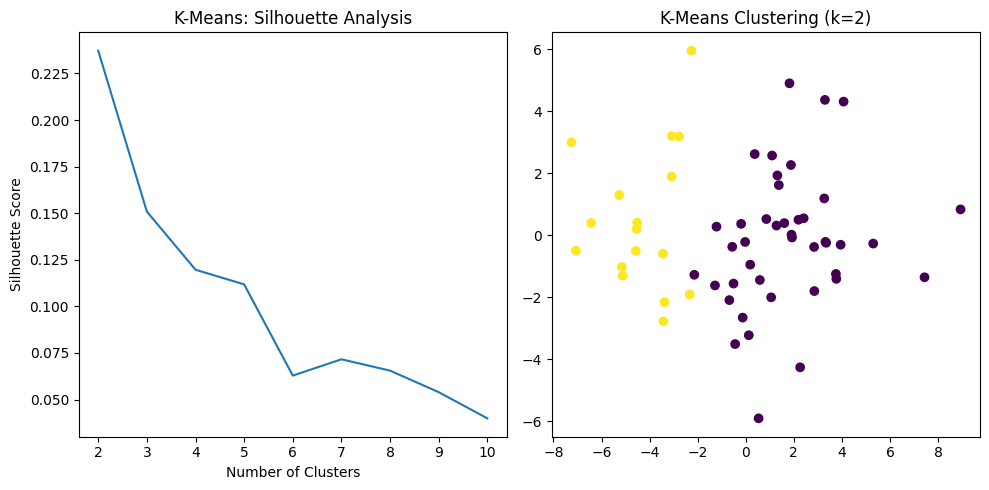

In [10]:
kmeans_labels = kmeans_clustering(data_pca)

In [11]:
evaluate_clustering(data_pca, kmeans_labels)

Silhouette Score: 0.2372
Calinski-Harabasz Index: 18.3457
Davies-Bouldin Index: 1.5602
Dunn Index: 0.2856


## K-means Clustering Loop

This code iterates through a range of cluster numbers (from 2 to 10) and performs the following steps for each:

1. **Initialize K-means**: Creates a K-means model with the current number of clusters.
2. **Fit and Predict**: Applies the K-means algorithm to the PCA-transformed data and gets cluster labels.
3. **Evaluate**: Calls the `evaluate_clustering` function to assess the clustering quality.

### Key Components:
- **Loop Range**: `range(2, 11)` - tests cluster numbers from 2 to 10.
- **KMeans Parameters**:
  - `n_clusters`: Set to the current iteration value.
  - `random_state=42`: Ensures reproducibility.
- **Input Data**: `data_pca` (presumably PCA-transformed dataset).
- **Output**: Prints evaluation metrics for each cluster configuration.

### Purpose:
This loop helps in determining the optimal number of clusters by comparing the evaluation metrics across different cluster counts.


In [12]:
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    print(f"\nEvaluation for {n_clusters} clusters:")
    evaluate_clustering(data_pca, labels)


Evaluation for 2 clusters:
Silhouette Score: 0.2372
Calinski-Harabasz Index: 18.3457
Davies-Bouldin Index: 1.5602
Dunn Index: 0.2856

Evaluation for 3 clusters:
Silhouette Score: 0.1509
Calinski-Harabasz Index: 14.0211
Davies-Bouldin Index: 1.8149
Dunn Index: 0.3295

Evaluation for 4 clusters:
Silhouette Score: 0.1197
Calinski-Harabasz Index: 11.5042
Davies-Bouldin Index: 1.9071
Dunn Index: 0.2711

Evaluation for 5 clusters:
Silhouette Score: 0.1118
Calinski-Harabasz Index: 9.7274
Davies-Bouldin Index: 1.7561
Dunn Index: 0.3080

Evaluation for 6 clusters:
Silhouette Score: 0.0629
Calinski-Harabasz Index: 8.2304
Davies-Bouldin Index: 1.8391
Dunn Index: 0.2905

Evaluation for 7 clusters:
Silhouette Score: 0.0716
Calinski-Harabasz Index: 7.9412
Davies-Bouldin Index: 1.8680
Dunn Index: 0.3080

Evaluation for 8 clusters:
Silhouette Score: 0.0655
Calinski-Harabasz Index: 7.1117
Davies-Bouldin Index: 1.9449
Dunn Index: 0.2905

Evaluation for 9 clusters:
Silhouette Score: 0.0540
Calinski-Hara

### Finding the Optimal Number of Clusters using Silhouette Score

In this cell, we perform the following steps to determine the optimal number of clusters for K-means clustering using the Silhouette Score:

1. **Initialize Variables**:
   - `best_silhouette`: To store the best (highest) Silhouette Score found during the iterations.
   - `best_n_clusters`: To store the number of clusters corresponding to the best Silhouette Score.

2. **Iterate Over Different Numbers of Clusters**:
   - We use a `for` loop to iterate over the number of clusters (`n_clusters`) from 2 to 10.
   - For each value of `n_clusters`, we:
     - Create a K-means clustering model with `n_clusters` clusters.
     - Fit the model to the data (`data_pca`) and obtain the cluster labels (`labels`).

3. **Compute Silhouette Score**:
   - The Silhouette Score (`sil_score`) is computed to measure how similar each point is to its own cluster compared to other clusters. A higher Silhouette Score indicates better-defined clusters.

4. **Update the Best Score**:
   - If the current `sil_score` is greater than the previously stored `best_silhouette`, update `best_silhouette` and `best_n_clusters` to reflect the current values.

5. **Print the Results**:
   - After the loop completes, print the best Silhouette Score and the corresponding number of clusters.



In [13]:
best_silhouette = -1
best_n_clusters = 0

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    sil_score = silhouette_score(data_pca, labels)
    
    if sil_score > best_silhouette:
        best_silhouette = sil_score
        best_n_clusters = n_clusters

print(f"Best Silhouette Score: {best_silhouette:.4f} (with {best_n_clusters} clusters)")

Best Silhouette Score: 0.2372 (with 2 clusters)


In [14]:
kmeans = KMeans(n_clusters=3, random_state=42)


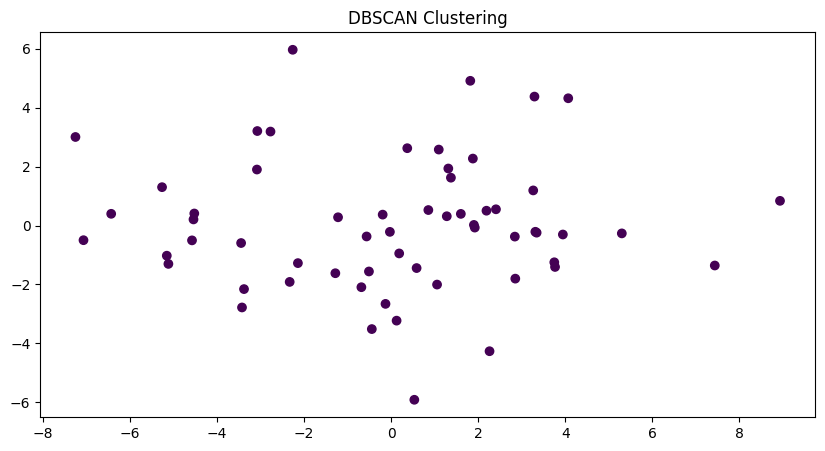

In [15]:
dbscan_labels = dbscan_clustering(data_pca)

In [16]:
# BEST MODEL
# K means for 3 clusters
kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans_model.fit_predict(data_pca)
kmeans_model.cluster_centers_


array([[ 1.75422750e+00, -2.09288355e-01,  2.16784605e-01,
        -5.20690022e-02, -6.02049254e-02, -3.80138441e-02,
        -5.38254722e-02,  4.11346840e-02, -5.06240244e-02,
         1.79249012e-02, -1.01328005e-02, -1.92587933e-02,
         2.97538743e-02,  1.85224723e-02,  4.03768898e-02,
        -1.58605023e-03, -1.43254823e-02,  1.49417211e-02,
        -3.16185577e-03, -2.71676677e-02,  1.67872782e-02,
         1.61904762e+00],
       [-4.33397381e+00,  5.17065347e-01, -5.35585495e-01,
         1.28641064e-01,  1.48741580e-01,  9.39165560e-02,
         1.32980578e-01, -1.01626866e-01,  1.25071119e-01,
        -4.42850500e-02,  2.50339777e-02,  4.75805482e-02,
        -7.35095718e-02, -4.57614021e-02, -9.97546688e-02,
         3.91847703e-03,  3.53923679e-02, -3.69148404e-02,
         7.81164366e-03,  6.71201203e-02, -4.14744520e-02,
         1.76470588e-01]])

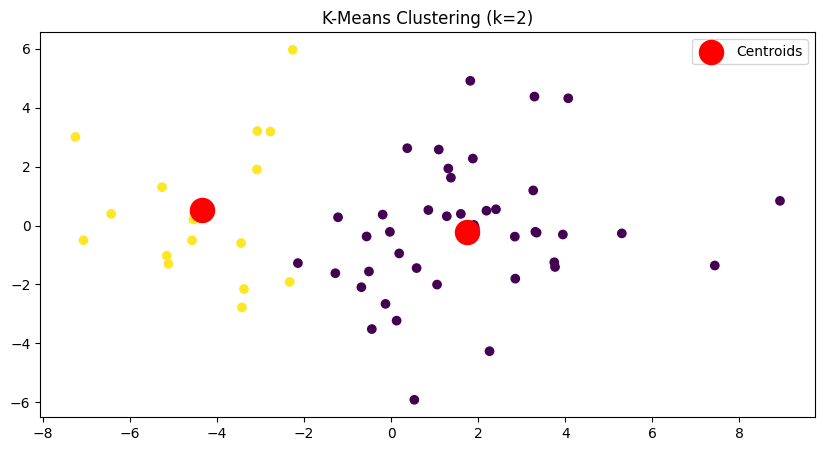

In [17]:
# Print K means with 3 clusters
plt.figure(figsize=(10, 5))
plt.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-Means Clustering (k=2)')
plt.legend()
plt.show()

## Function: Hierarchical Clustering with Dendrogram

This function `plot_hierarchical_clustering` performs hierarchical clustering on the input data and generates a dendrogram to visualize the clustering hierarchy.


In [19]:
def plot_hierarchical_clustering(data, method='ward', metric='euclidean', title='Hierarchical Clustering Dendrogram'):
    # Compute the distance matrix
    distance_matrix = pdist(data, metric=metric)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method=method)
    
    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

    return linkage_matrix


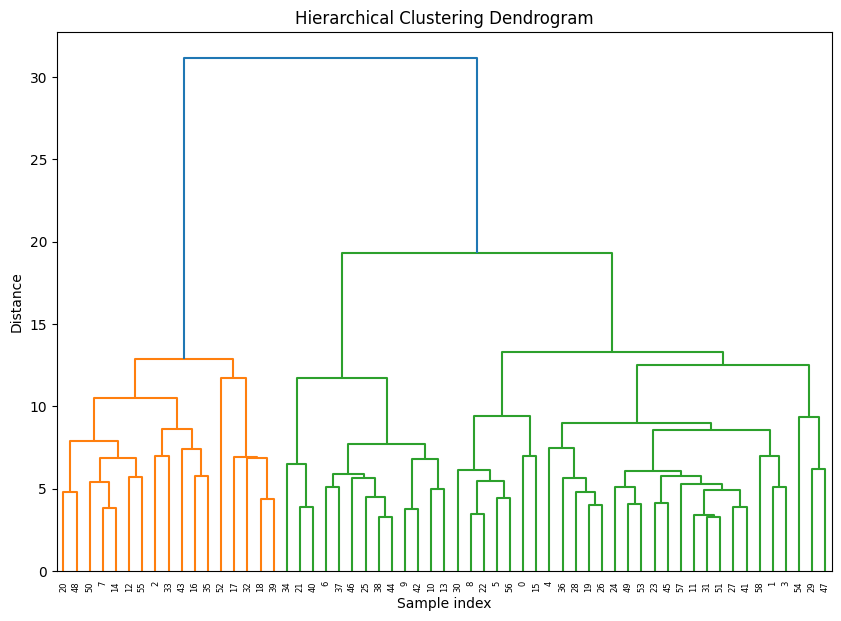

array([[ 31.        ,  51.        ,   3.25860802,   2.        ],
       [ 38.        ,  44.        ,   3.28527954,   2.        ],
       [ 11.        ,  59.        ,   3.38593962,   3.        ],
       [  8.        ,  22.        ,   3.46251959,   2.        ],
       [  9.        ,  42.        ,   3.79077126,   2.        ],
       [  7.        ,  14.        ,   3.8503911 ,   2.        ],
       [ 27.        ,  41.        ,   3.8617517 ,   2.        ],
       [ 21.        ,  40.        ,   3.8826028 ,   2.        ],
       [ 19.        ,  26.        ,   3.98867846,   2.        ],
       [ 49.        ,  53.        ,   4.07322509,   2.        ],
       [ 23.        ,  45.        ,   4.14001837,   2.        ],
       [ 18.        ,  39.        ,   4.35692669,   2.        ],
       [  5.        ,  56.        ,   4.40949144,   2.        ],
       [ 25.        ,  60.        ,   4.47624945,   3.        ],
       [ 20.        ,  48.        ,   4.78599254,   2.        ],
       [ 28.        ,  67

In [22]:
plot_hierarchical_clustering(data_pca, metric='euclidean')

In [21]:
joblib.dump(kmeans_model, r'..\models\05_kmeans_model.pkl')


['..\\models\\05_kmeans_model.pkl']

### Usage
If you want to use model you have to apply PCA then use it in model 
enjoy